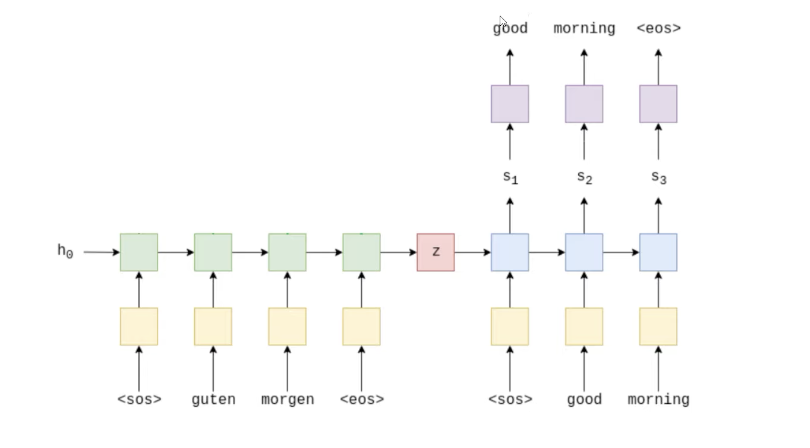

In [1]:
!pip install torchtext==0.04

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import numpy as np
import spacy
import random
import math
import time
from torch.utils.tensorboard import SummaryWriter
# Garbage Collector - use it like gc.collect()
import gc

**Tokenizer**

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python3 -m spacy download de_core_news_sm

2023-04-25 15:42:13.328308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 85.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
spacy_ger = spacy.load('en_core_web_sm')
spacy_eng = spacy.load('de_core_news_sm')

In [5]:
def german_tokenizer(text):
  return [tok.text for tok in spacy_ger.tokenizer(text)] 
def english_tokenizer(text):
  return [tok.text for tok in spacy_eng.tokenizer(text)] #hello my name is -> ['hello','my','name','is']

#construct Field define how preperocessing 
german= Field(tokenize=german_tokenizer, lower=True, init_token='<sos>', eos_token='<eos>')
english= Field(tokenize=english_tokenizer, lower=True, init_token='<sos>', eos_token='<eos>')


**Data**

In [6]:
train_data, validation_data, test_data= Multi30k.splits(exts=('.de','.en'), fields=(german, english))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 5.46MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.62MB/s]

downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.56MB/s]


In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(validation_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [8]:
print(vars(train_data.examples[0]))
print(vars(validation_data.examples[0]))

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'i', 'm', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['eine', 'gruppe', 'von', 'männern', 'lädt', 'baumwolle', 'auf', 'einen', 'lastwagen'], 'trg': ['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']}


**Vocabulary**

In [9]:
german.build_vocab(train_data, max_size=10000, min_freq=2)# words that occur only once are not included
english.build_vocab(train_data, max_size=10000, min_freq=2)


In [10]:
print(f"Unique tokens in source (de) vocabulary: {len(german.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(english.vocab)}")


Unique tokens in source (de) vocabulary: 7874
Unique tokens in target (en) vocabulary: 5972


In [11]:
#input_size = vocabulary size of german size
#embedding_size = each word is mapped to embedding space
#num_layers = number of layers of lstm
#hidden_size = Hidden dimension determines the feature vector size of the hidden state

class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(input_size, embedding_size) #vocabulary x embedding size
    #first word passes through embedding and then rnn so inputsize for rnn is embedding size and output is hidden size
    self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout= p)

  def forward(self,x): 
    # x is a long vector of input of all the indexes of the word that is in the vocabulary 
    # the sentence is tokenized and mapped to some index coresponding to where it is in vocabulary and then that vector is sent into the lstm
    # so x is a vector of indxes x shape: (seq_length, N) N= batch_size
    embedding = self.dropout(self.embedding(x)) 
    # embedding shape : (seq_length, N, embedding size )
    #each word in each sequence is also mapped to some embedding size 
    outputs, (hidden,cell) = self.rnn(embedding)
    #we care only about hidden and cell since it is the context vector 

    return hidden, cell 


In [12]:
#input_size = english vocabulary size
#output_size = english vocabulary size, the output is a vector corresponding to values for each word that is in our vocab
#say we have 10000 words in our english voacbulary we will have output that is 10000 dimensional where each node represents the probability that it its that 
#word in the vocabulary
#embedding_size = each word is mapped to embedding space
#num_layers = number of layers of lstm
class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
    super(Decoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(input_size, embedding_size) #vocabulary x embedding size
    self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout= p)
    #hidden size of encoder and decoder are same
    self.fc = nn.Linear(hidden_size, output_size)
  
  def forward(self, x, hidden,cell):#x shape:(N) but we want (1,N) cause its gonna predict one word at a time so given previous 
  #hidden and cell state and previous predicted word so 1 represents single word so N batches of single word at a time this contrast to encoder that 
  #took sequence length of words at a time cause in encoder we can send the entire german sentence but during prediction we are doing it one word at a time
    x = x.unsqueeze(0) # so added a dimension (1,N)
    embedding = self.dropout(self.embedding(x))
    #embedding shape: (1,N,embedding_size)
    outputs, (hidden,cell)=self.rnn(embedding,(hidden,cell)) #(hidden,cell) used for next word prediction
    # shape of outputs: (1,N,hidden_size)
    predictions = self.fc(outputs)
    # shape of predictions : (1,N,length_of_eng_vocab)
    predictions = predictions.squeeze(0) #remove the 1

    return predictions, hidden, cell





In [13]:
class Seq2Seq(nn.Module):
  def __init__(self,encoder, decoder,device):
    super(Seq2Seq,self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, source, target, teacher_force_ratio=0.5):
    #send source german sentence and correct sentence
    #teacher force ratio--> the predicted output of first timestep is input to the next timestep so that it can predict the next word
    #now the previous predicted output is not right all the time so what we want to do is use the previous predicted output for calculating loss
    #but for input to next timestep we input the real/ what is should be
    #and sometimes we use the real value as input and sometimes we use the predicted output of previous time step so the teacher forcing ratio=0.5 
    #means 50% times we do either
    batch_size = source.shape[1]
    # print("source.shape",source.shape)
    # print("batch_size", batch_size)
    target_len = target.shape[0]
    # print("target_len", target_len)
    target_vocab_size = len(english.vocab)
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
    hidden, cell = self.encoder(source)
    x = target[0] #grab start token
    # and word by word we pass it to the decoder
    for t in range(1, target_len):
      output, hidden, cell = self.decoder(x, hidden, cell)#pass hidden and cell from encoder
      #we are adding ouput along outputs first dimension
      outputs[t] = output
      #output (N, english_vocab_size) so for each batch if we take argmax for this dimension i.e english_vocab_size we get index for the word 
      best_guess = output.argmax(1)
      #next input to the decoder will be target word if this random.random() is between zero and one is less than 0.5 otherwise it will be the best_guess
      x = target[t] if random.random() < teacher_force_ratio else best_guess 
    return outputs
    





In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**TRAINING**

In [15]:
# training hyperparameters
num_epochs = 20
learning_rate = 0.001
batch_size = 64

#model hyperparameters
load_model = False
input_size_encoder = len(german.vocab)
input_size_decoder = len(english.vocab)
output_size =  len(english.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024 
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data,validation_data,test_data),
    batch_size= batch_size, 
    sort_within_batch= True,
    sort_key = lambda x : len(x.src),device = device)

In [16]:
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout)
decoder_net = Decoder(input_size_decoder, decoder_embedding_size, hidden_size,num_layers,dec_dropout, output_size)
model = Seq2Seq(encoder_net, decoder_net,device).to(device)

In [17]:
optimizer = optim.Adam(model.parameters())
pad_idx = english.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) #if we have padded so that all egs in batch are same length then we dont want o pay anything 
# for that in the loss
if load_model :
  print("Loading Model....")
  model.load_state_dict(torch.load('my_checkpoint.pth.ptar')['state_dict'])
  optimizer.load_state_dict(torch.load('my_checkpoint.pth.ptar')['state_dict'])






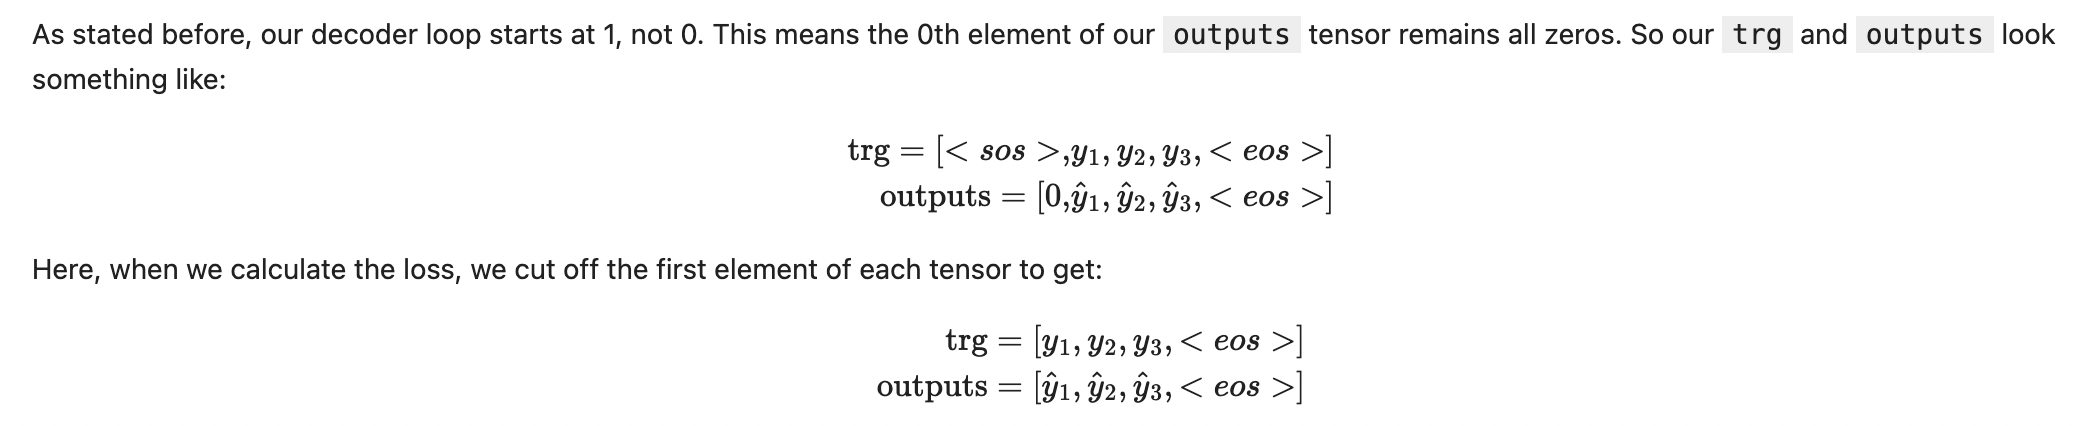

At each iteration:

get the source and target sentences from the batch, 
 and 
zero the gradients calculated from the last batch
feed the source and target into the model to get the output, 
as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with .view
we slice off the first column of the output and target tensors as mentioned above
calculate the gradients with loss.backward()
clip the gradients to prevent them from exploding (a common issue in RNNs)
update the parameters of our model by doing an optimizer step
sum the loss value to a running total
Finally, we return the loss that is averaged over all batches.

In [18]:
#model.train() #This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        # if i == 1:
        #   print("source",src)
        #   print("target",trg)
        #   print("output",output)
        #   print("ouput shape",output.shape)
        #as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with .view 
        #trg = [trg len, batch size]
        #output shape: [trg len, batch size, output dim]
        #eg for each batch we have say 20 outputs from the model so we can cocatenate (trg len, batch size) so target length amount of output that is sent to crossentipy

      
        output_dim = output.shape[-1] #size of the vocabulary
       
        # print("ouput_dim shape",output_dim)
        #output[1:] cause 0th is start token 
        output = output[1:].view(-1, output_dim)#keep size of the vocabulary and merge rest dimensions
      
        # print("ouput shape",output.shape)
        trg = trg[1:].view(-1) # this becomes single trg len x batch size
        # print("trg shape",trg.shape)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

ouput shape torch.Size([20, 64, 5972])
ouput_dim shape 5972
ouput shape torch.Size([1216, 5972])
trg shape torch.Size([1216])
source.shape torch.Size([38, 64])
batch_size 64
target_len 41
source tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   5,    8,    8,  ...,    5,    5,  333],
        [  99,   73,   38,  ...,   13,   13,   40],
        ...,
        [4606,  787,  129,  ...,  242,   52,  408],
        [   4,    4,    4,  ...,    4,    4,    4],
        [   3,    3,    3,  ...,    3,    3,    3]], device='cuda:0')
target tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  4,   4,   4,  ...,   4,   4, 171],
        [ 23,  23,  38,  ...,   9,   9,  37],
        ...,
        [  1,   1,   3,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0')
output tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 3.7048, -9.5541, -9.4317,  ..., -9.0004, -9.4597, -6.8437],
         [ 3.5025, -9.2503, -9.0327,  ..., -8.7217, -9.1171, -6.7071],
         [ 3.7129, -9.7030, -9.4591,  ..., -9.0968, -9.5426, -7.0018],
         ...,
         [ 3.7296, -9.6493, -9.4895,  ..., -9.1265, -9.5932, -6.9246],
         [ 3.6163, -9.3714, -9.2066,  ..., -8.8415, -9.2537, -6.7364],
         [ 2.0831, -5.6521, -5.5515,  ..., -5.4292, -5.6429, -4.7766]],

        [[ 3.4009, -7.2527, -7.1958,  ..., -6.8898, -7.4774, -4.6282],
         [ 3.0904, -6.6679, -6.4896,  ..., -6.3745, -6.7707, -4.2912],
         [ 3.1438, -6.8385, -6.6948,  ..., -6.5727, -6.9200, -4.4164],
         ...,
         [ 3.2533, -7.0808, -6.9902,  ..., -6.7052, -7.2332, -4.5315],
         [ 3.3698, -7.2499, -7.1494,  ..., -6.9113, -7.3801, -4.5604],
         [ 2.5271, -6.0504, -5.7963,  ..., -6.4186, -5.9893, -4.9858]],


In [25]:
def translate_sentence(model, sentence, german, english, device, max_length=50):
    # Load german tokenizer
    spacy_ger = spacy.load('de_core_news_sm')

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [german.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [english.vocab.stoi["<sos>"]]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    # remove start token
    return translated_sentence[1:]


In [20]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        translated_sententce = translate_sentence(model, sentence, german, english, device, max_length=50)
        print("tranlated_sentence eg", translated_sententce)
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')
sentence = 'Jetzt mal Butter bei die Fische.'

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    if epoch %1 == 0:
      print("Saving checkpoint")
      checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
      torch.save(checkpoint, 'my_checkpoint.pth.ptar' )
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Saving checkpoint
tranlated_sentence eg ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'the', '.', '.', '.', '<eos>']
Epoch: 01 | Time: 0m 28s
	Train Loss: 3.482 | Train PPL:  32.527
	 Val. Loss: 3.894 |  Val. PPL:  49.094
Saving checkpoint
tranlated_sentence eg ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'the', 'the', '.', '.', '<eos>']
Epoch: 02 | Time: 0m 30s
	Train Loss: 3.206 | Train PPL:  24.670
	 Val. Loss: 3.712 |  Val. PPL:  40.940
Saving checkpoint
tranlated_sentence eg ['<unk>', '<unk>', '<unk>', '<unk>', 'the', 'the', 'the', '.', '.', '.', '<eos>']
Epoch: 03 | Time: 0m 29s
	Train Loss: 2.973 | Train PPL:  19.542
	 Val. Loss: 3.648 |  Val. PPL:  38.414
Saving checkpoint
tranlated_sentence eg ['<unk>', '<unk>', '<unk>', 'are', 'to', 'to', 'the', 'the', '.', '.', '.', '<eos>']
Epoch: 04 | Time: 0m 29s
	Train Loss: 2.802 | Train PPL:  16.475
	 Val. Loss: 3.573 |  Val. PPL:  35.640
Saving checkpoint
tranlated_sentence eg ['<unk>', '<unk>', '<unk>', '<unk>', 'at', 'the'